In [ ]:
import pandas as pd

metrics_rssm = pd.read_csv("/home/akopyane/rl/lumos/logs/overfit_debug/version_106/metrics.csv")
metrics_rssm

,gate/train-activity,gate/train-sparsity,gate/train-time-steps,latent/train-entropy,loss/train-coarse,loss/train-coarse-gripper,loss/train-coarse-static,loss/train-ctxt-sparsity,loss/train-gate-activity,loss/train-kl-c,loss/train-kl-p,loss/train-precise,loss/train-precise-gripper,loss/train-precise-static,loss/train-reconstr,loss/train-total,step
0,0.494629,0.494629,79.140625,107.112709,1783.274048,1898.243774,1668.304321,9.892578,0.0,7.694132,7.819057,1783.228027,1898.216064,1668.239868,3566.501953,3769.007568,0
1,0.501563,0.501563,80.250008,107.040733,1916.718018,2127.940918,1705.495117,10.031251,0.0,7.699389,7.749364,1916.804199,2128.117676,1705.490845,3833.522217,4038.781738,0
2,0.495605,0.495605,79.296875,107.037193,2150.973633,2619.277100,1682.669922,9.912109,0.0,7.821352,7.790213,2151.248291,2619.656982,1682.839478,4302.221680,4505.147461,0
3,0.510840,0.510840,81.734383,107.048050,1219.128662,959.452759,1478.804688,10.216798,0.0,7.770814,7.829975,1219.220581,959.669617,1478.771484,2438.349121,2647.365234,0
4,0.497559,0.497559,79.609375,107.048828,1172.801758,844.591614,1501.011841,9.951172,0.0,7.684004,7.864944,1172.867920,844.755798,1500.979980,2345.669678,2549.357910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7006,0.000000,0.000000,0.000000,55.985767,309.400330,367.829803,250.970856,0.000000,0.0,14.741445,13.502764,297.191803,350.510345,243.873276,606.592163,615.065430,6995
7007,0.000000,0.000000,0.000000,60.502613,323.175720,380.162750,266.188690,0.000000,0.0,14.532288,13.027521,307.284027,356.162201,258.405853,630.459717,638.727661,6996
7008,0.000000,0.000000,0.000000,64.594833,414.660614,509.057190,320.264038,0.000000,0.0,17.346624,16.429356,396.528259,480.831116,312.225403,811.188843,821.321655,6997
7009,0.000098,0.000098,0.015625,63.618488,410.846802,555.648071,266.045502,0.001953,0.0,16.530355,15.688115,392.323059,524.639160,260.006958,803.169861,812.874451,6998


In [3]:
import pandas as pd

metrics_crssm = pd.read_csv("/home/akopyane/rl/lumos/logs/overfit_debug/version_108/metrics.csv")
metrics_crssm

,gate/train-activity,gate/train-sparsity,gate/train-time-steps,latent/train-entropy,loss/train-coarse,loss/train-coarse-gripper,loss/train-coarse-static,loss/train-ctxt-sparsity,loss/train-gate-activity,loss/train-kl-c,loss/train-kl-p,loss/train-precise,loss/train-precise-gripper,loss/train-precise-static,loss/train-reconstr,loss/train-total,step
0,0.470508,0.470508,75.281250,107.129883,1783.322266,1898.203491,1668.441040,9.410156,0.0,7.978583,8.128507,1783.324829,1898.179688,1668.469971,3566.646973,3759.682129,0
1,0.503223,0.503223,80.515625,107.061089,1916.794922,2127.971436,1705.618530,10.064453,0.0,7.809896,7.964167,1916.772461,2127.960693,1705.584229,3833.567383,4039.588623,0
2,0.523340,0.523340,83.734375,107.048645,2150.969971,2619.195312,1682.744507,10.466797,0.0,7.853634,7.914708,2151.064697,2619.320557,1682.808838,4302.034668,4516.101074,0
3,0.483594,0.483594,77.375000,107.061806,1219.142700,959.499695,1478.785767,9.671875,0.0,7.769535,8.022677,1219.094360,959.472290,1478.716431,2438.237061,2636.412109,0
4,0.481445,0.481445,77.031250,107.068092,1172.808350,844.613281,1501.003418,9.628906,0.0,7.778566,7.953529,1172.871826,844.751160,1500.992432,2345.680176,2542.978027,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0.003027,0.003027,0.484375,89.646530,675.012817,709.645691,640.379883,0.060547,0.0,8.340721,8.214213,661.421875,690.253418,632.590271,1336.434692,1342.612061,495
506,0.004199,0.004199,0.671875,90.658409,699.133423,846.243958,552.022949,0.083984,0.0,6.340754,6.361894,664.343018,819.757141,508.928925,1363.476440,1368.966919,496
507,0.007422,0.007422,1.187500,88.666664,740.066528,912.493591,567.639465,0.148438,0.0,4.591680,4.570728,704.928955,865.410278,544.447693,1444.995483,1450.713013,497
508,0.006348,0.006348,1.015625,89.602470,597.279419,622.198730,572.360168,0.126953,0.0,8.126433,7.513258,565.464600,584.170105,546.759094,1162.744019,1169.974976,498


In [9]:
import pandas as pd

metrics_crssm = pd.read_csv("/home/akopyane/rl/lumos/logs/overfit_debug/version_108/metrics.csv")
metrics_crssm

,gate/train-activity,gate/train-sparsity,gate/train-time-steps,latent/train-entropy,loss/train-coarse,loss/train-coarse-gripper,loss/train-coarse-static,loss/train-ctxt-sparsity,loss/train-gate-activity,loss/train-kl-c,loss/train-kl-p,loss/train-precise,loss/train-precise-gripper,loss/train-precise-static,loss/train-reconstr,loss/train-total,step
0,0.470508,0.470508,75.281250,107.129883,1783.322266,1898.203491,1668.441040,9.410156,0.0,7.978583,8.128507,1783.324829,1898.179688,1668.469971,3566.646973,3759.682129,0
1,0.503223,0.503223,80.515625,107.061089,1916.794922,2127.971436,1705.618530,10.064453,0.0,7.809896,7.964167,1916.772461,2127.960693,1705.584229,3833.567383,4039.588623,0
2,0.523340,0.523340,83.734375,107.048645,2150.969971,2619.195312,1682.744507,10.466797,0.0,7.853634,7.914708,2151.064697,2619.320557,1682.808838,4302.034668,4516.101074,0
3,0.483594,0.483594,77.375000,107.061806,1219.142700,959.499695,1478.785767,9.671875,0.0,7.769535,8.022677,1219.094360,959.472290,1478.716431,2438.237061,2636.412109,0
4,0.481445,0.481445,77.031250,107.068092,1172.808350,844.613281,1501.003418,9.628906,0.0,7.778566,7.953529,1172.871826,844.751160,1500.992432,2345.680176,2542.978027,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,0.001563,0.001563,0.250000,78.102249,564.074951,669.998230,458.151672,0.031250,0.0,10.178185,9.494544,539.587158,631.986450,447.187805,1103.662109,1110.188965,1095
1106,0.001855,0.001855,0.296875,76.937851,471.372192,489.445709,453.298645,0.037109,0.0,7.118423,6.925187,434.481567,430.067383,438.895721,905.853760,910.809021,1096
1107,0.002344,0.002344,0.375000,85.606949,651.569458,903.687500,399.451416,0.046875,0.0,11.596919,12.010220,614.218506,834.670105,393.766907,1265.787964,1273.807617,1097
1108,0.001465,0.001465,0.234375,78.326294,486.186890,650.731018,321.642731,0.029297,0.0,8.265658,8.889052,478.886902,615.704712,342.069092,965.073792,970.806152,1098


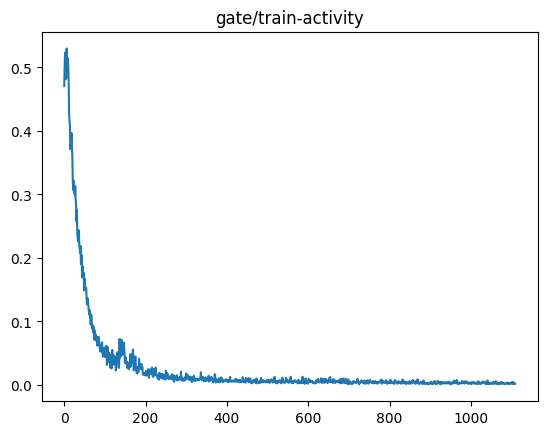

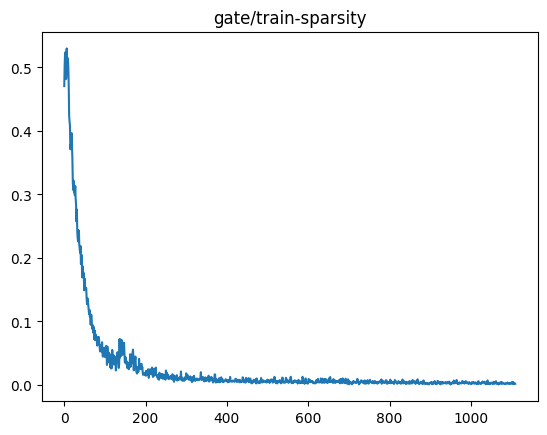

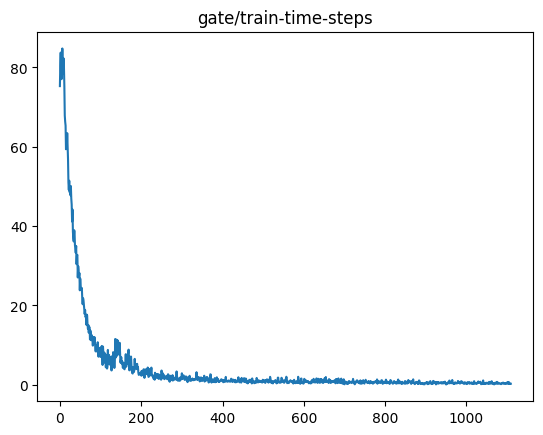

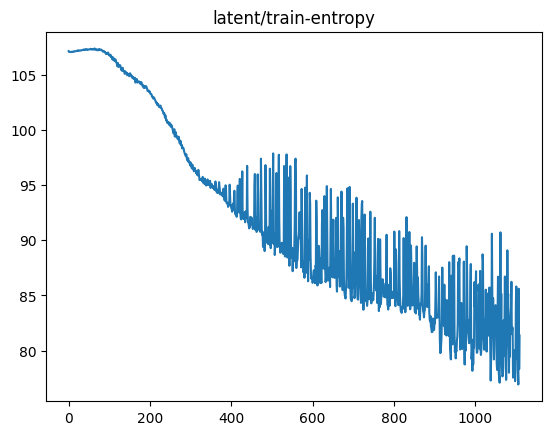

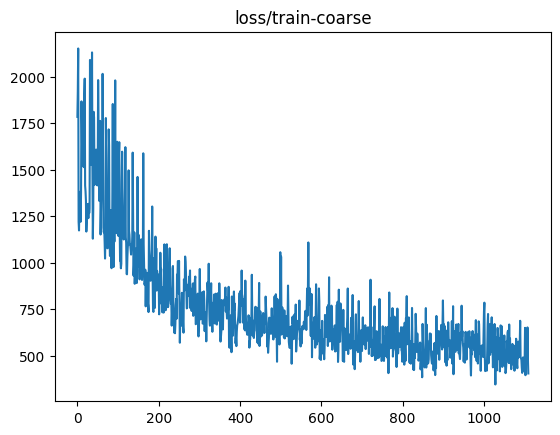

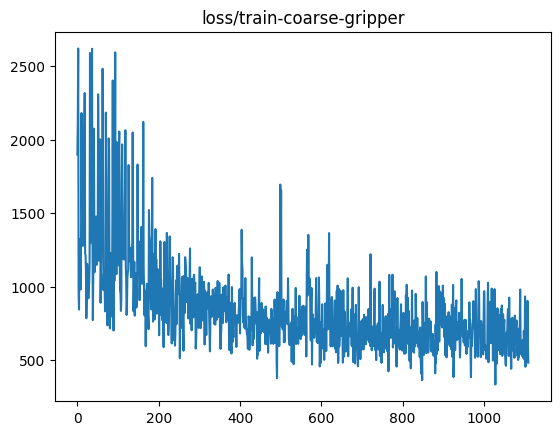

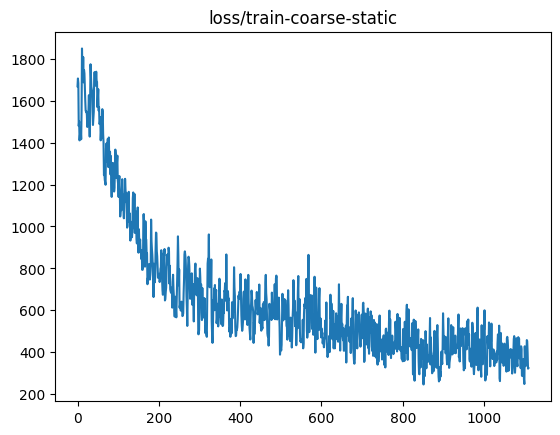

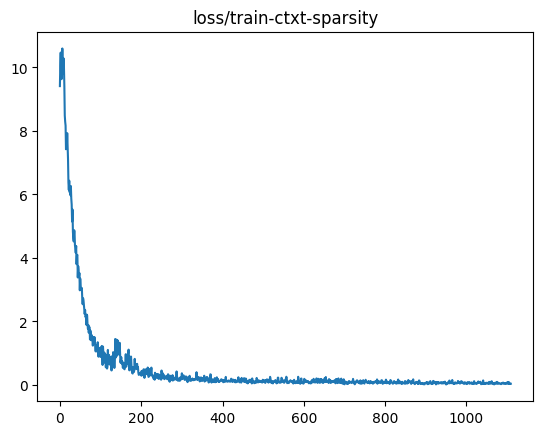

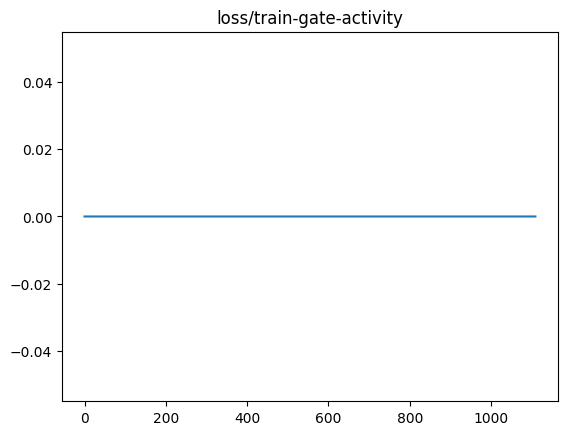

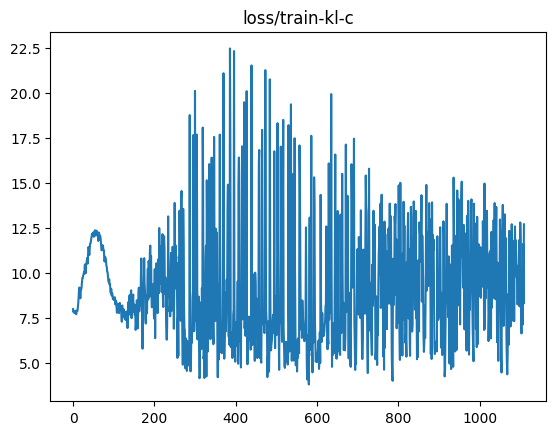

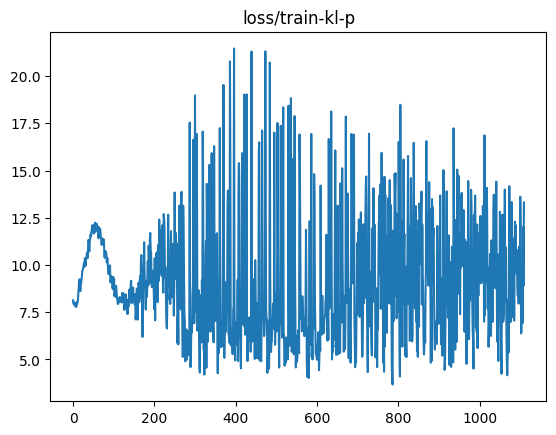

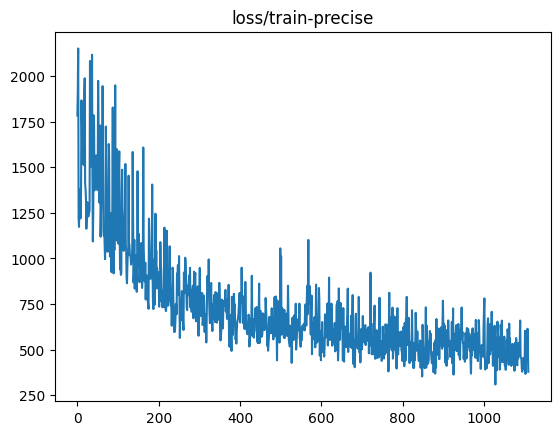

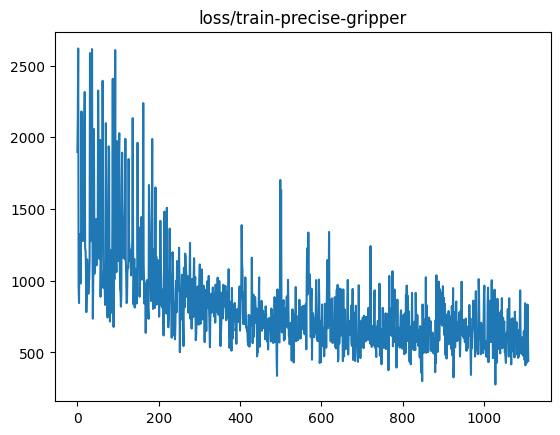

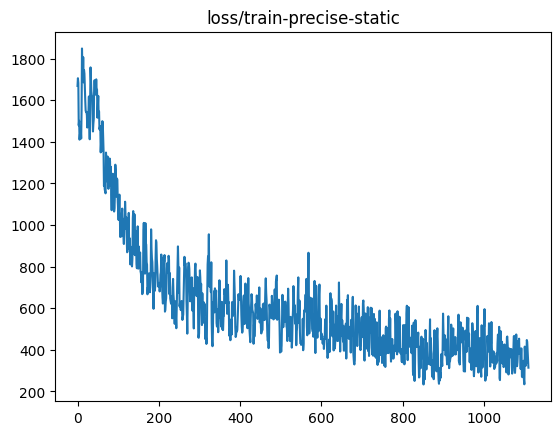

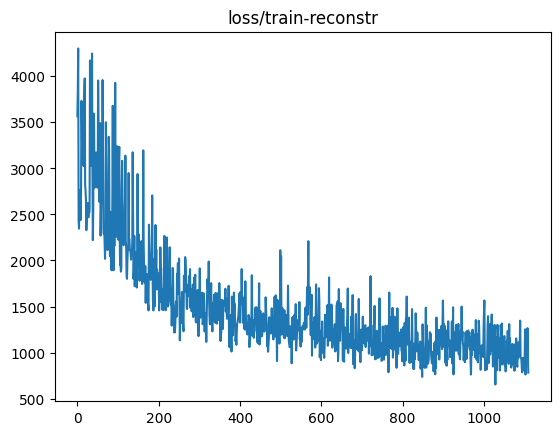

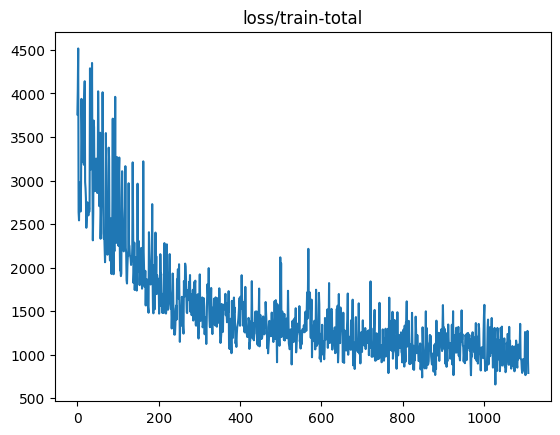

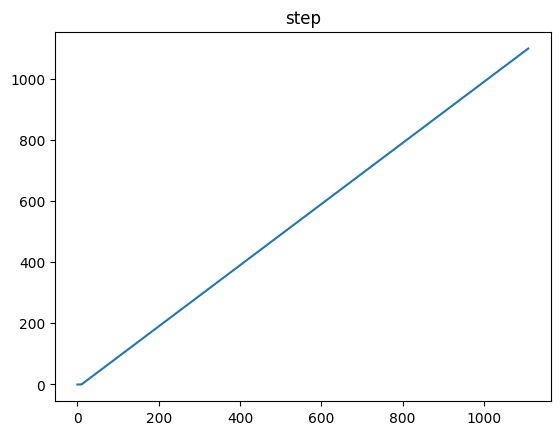

In [13]:
for col in metrics_crssm.columns:
    plt.title(col)
    plt.plot(metrics_crssm[col])
    plt.show()

In [6]:
metrics_rssm.columns

Index(['gate/train-activity', 'gate/train-sparsity', 'gate/train-time-steps',
       'latent/train-entropy', 'loss/train-coarse',
       'loss/train-coarse-gripper', 'loss/train-coarse-static',
       'loss/train-ctxt-sparsity', 'loss/train-gate-activity',
       'loss/train-kl-c', 'loss/train-kl-p', 'loss/train-precise',
       'loss/train-precise-gripper', 'loss/train-precise-static',
       'loss/train-reconstr', 'loss/train-total', 'step'],
      dtype='object')

In [4]:
import matplotlib.pyplot as plt
plt.plot(metrics_rssm["loss/train-kl-c"])

NameError: name 'metrics_rssm' is not defined

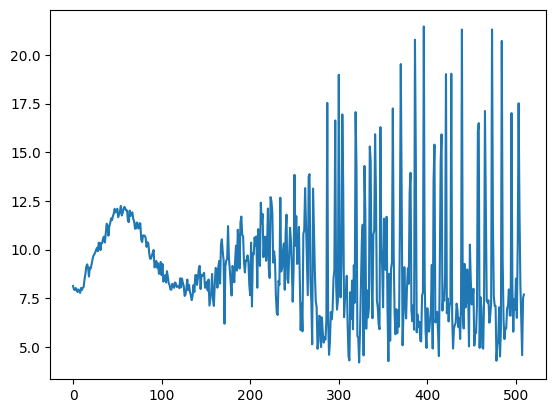

In [5]:
plt.plot(metrics_crssm["loss/train-kl-p"])

In [3]:
plt.plot(metrics["loss/train-kl-c"])

NameError: name 'plt' is not defined

In [14]:
metrics.columns

Index(['gate/train-activity', 'gate/train-sparsity', 'gate/train-time-steps',
       'latent/train-entropy', 'loss/train-coarse',
       'loss/train-coarse-gripper', 'loss/train-coarse-static',
       'loss/train-ctxt-sparsity', 'loss/train-gate-activity',
       'loss/train-kl-c', 'loss/train-kl-p', 'loss/train-precise',
       'loss/train-precise-gripper', 'loss/train-precise-static',
       'loss/train-reconstr', 'loss/train-total', 'step'],
      dtype='object')

In [2]:
import pandas as pd
metrics = pd.read_csv("/home/akopyane/rl/lumos/logs/overfit_debug/version_105/metrics.csv")
metrics

,gate/train-activity,gate/train-sparsity,gate/train-time-steps,latent/train-entropy,loss/train-coarse,loss/train-coarse-gripper,loss/train-coarse-static,loss/train-ctxt-sparsity,loss/train-gate-activity,loss/train-kl-c,loss/train-kl-p,loss/train-precise,loss/train-precise-gripper,loss/train-precise-static,loss/train-reconstr,loss/train-total,step
0,0.487305,0.487305,77.968750,107.112480,1783.185791,1898.115479,1668.256226,9.746094,0.0,8.021181,8.060822,1783.296631,1898.363281,1668.229858,3566.482422,3766.229004,0
1,0.500391,0.500391,80.062500,107.044739,1916.647827,2127.876465,1705.419189,10.007812,0.0,7.943358,8.055602,1916.690918,2128.029053,1705.352783,3833.338867,4038.294922,0
2,0.492969,0.492969,78.875000,107.060158,2150.959717,2619.252441,1682.666992,9.859375,0.0,7.752628,7.926959,2151.049316,2619.442139,1682.656250,4302.008789,4503.900391,0
3,0.484180,0.484180,77.468750,107.040459,1219.117188,959.539734,1478.694702,9.683594,0.0,8.113884,8.131966,1219.202881,959.590942,1478.814819,2438.320068,2636.865723,0
4,0.484863,0.484863,77.578125,107.042381,1172.806152,844.685730,1500.926636,9.697266,0.0,8.118689,8.136532,1172.859985,844.695496,1501.024414,2345.666016,2544.487793,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,0.000391,0.000391,0.062500,64.266479,404.844574,535.528198,274.160950,0.007812,0.0,11.288727,11.063155,378.644226,486.539368,270.749054,783.488770,790.350586,2995
3006,0.000293,0.000293,0.046875,67.255577,455.336182,643.577454,267.094879,0.005859,0.0,10.300860,10.213417,419.644714,574.859558,264.429871,874.980896,881.252380,2996
3007,0.000391,0.000391,0.062500,64.995255,528.454956,734.144775,322.765106,0.007812,0.0,13.958412,14.252654,504.491364,695.681946,313.300781,1032.946289,1041.565918,2997
3008,0.000391,0.000391,0.062500,67.610191,323.210510,382.129944,264.291077,0.007812,0.0,13.374982,13.002505,301.404541,344.316162,258.492950,624.615051,632.684570,2998


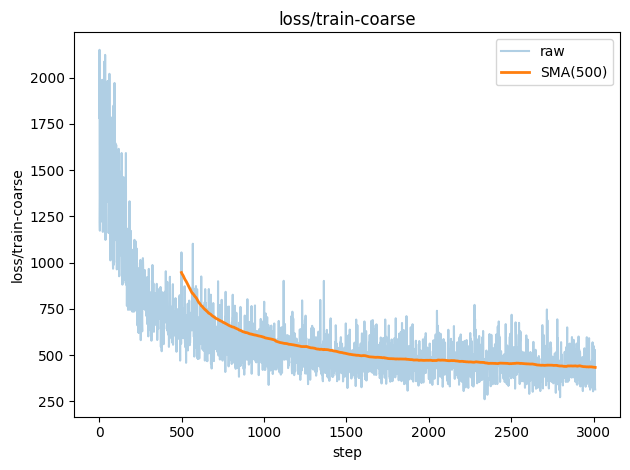

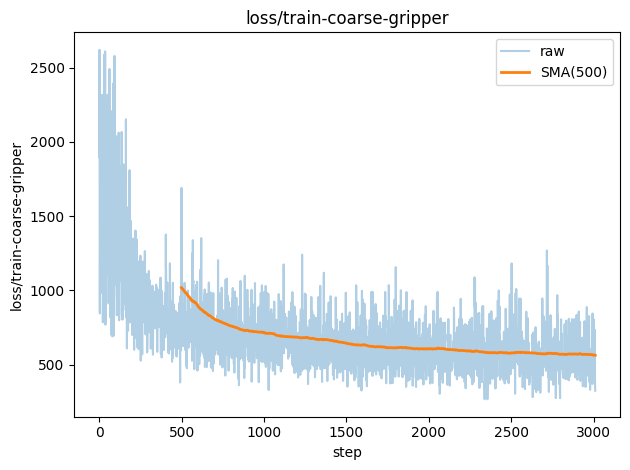

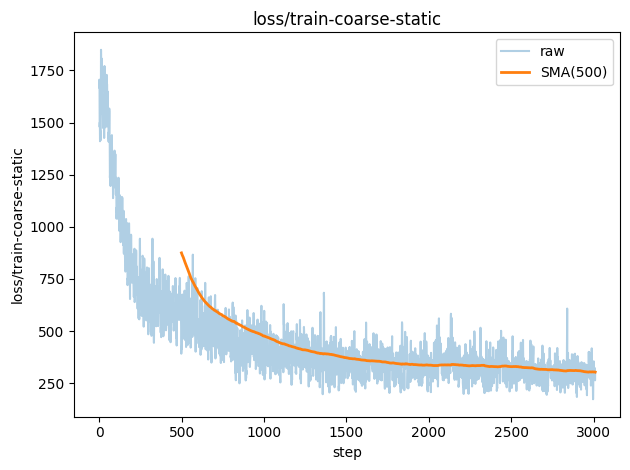

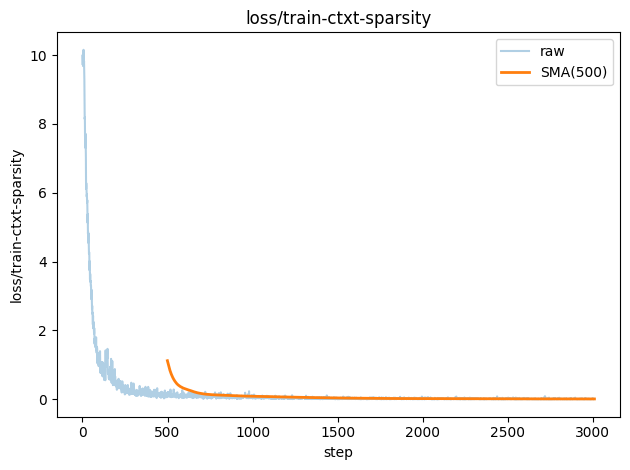

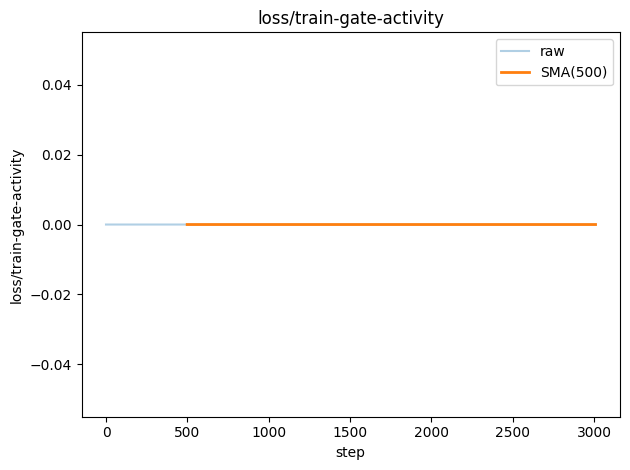

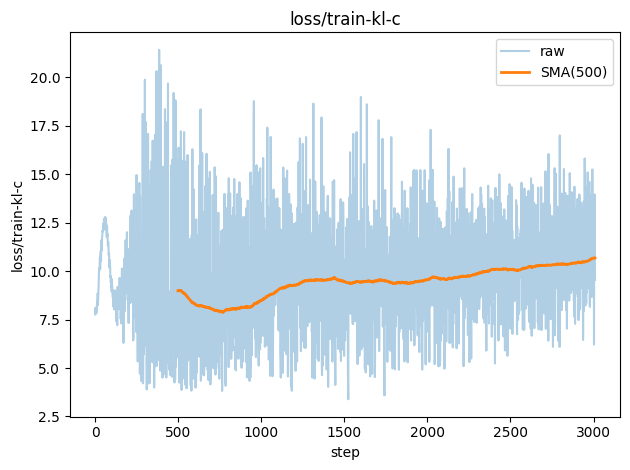

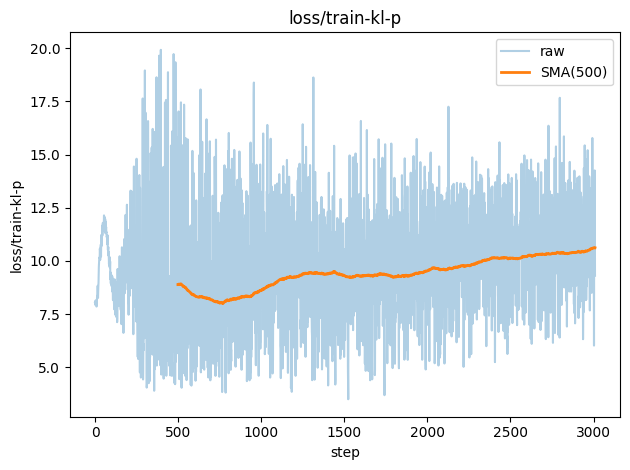

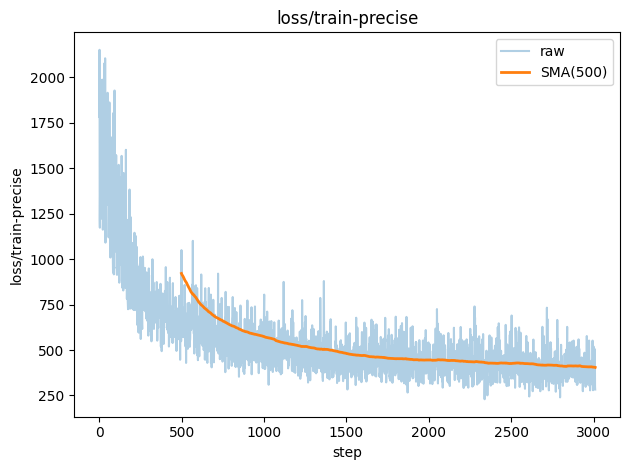

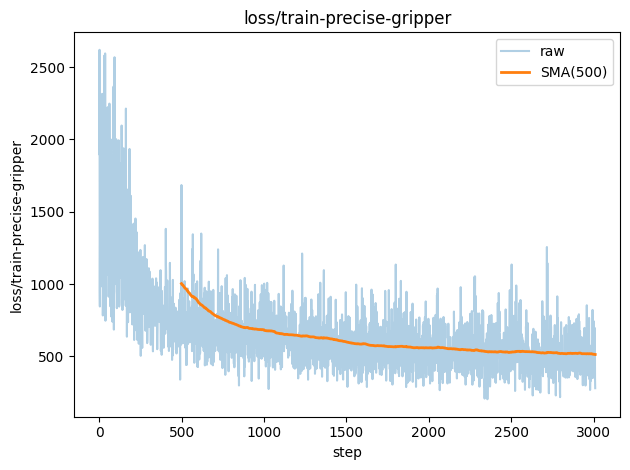

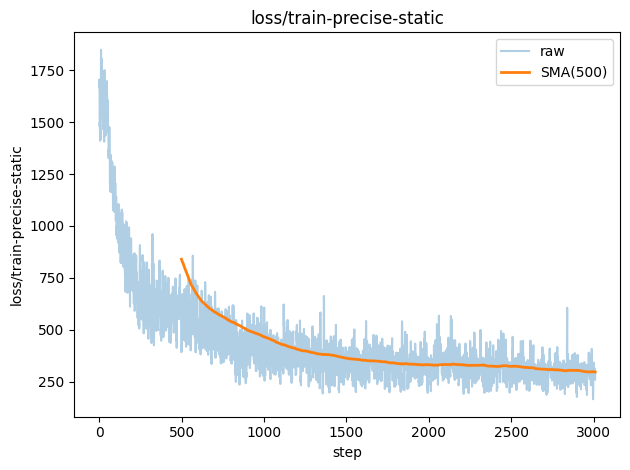

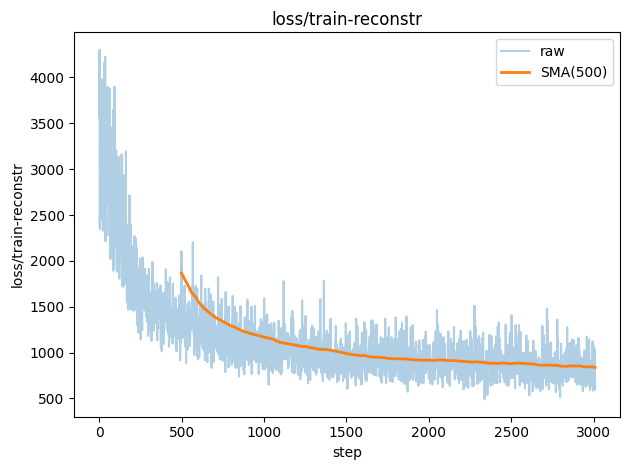

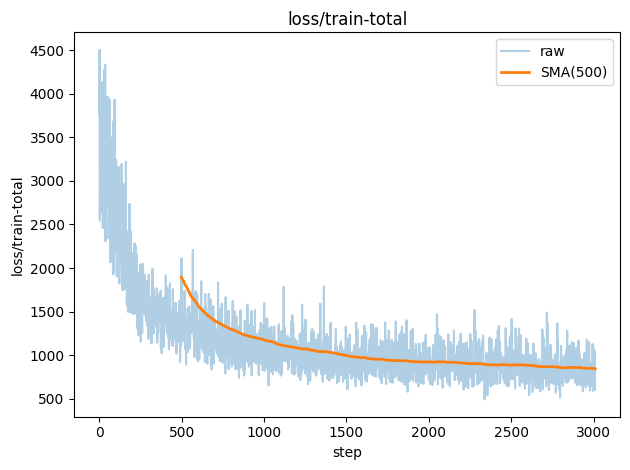

In [3]:
import numpy as np
import matplotlib.pyplot as plt

window = 500 

for col in metrics.columns:
        if "loss" in col:
            y = np.asarray(metrics[col], dtype=float)
            x = np.arange(len(y))

            plt.plot(x, y, alpha=0.35, label="raw")

            # simple moving average via convolution
            if len(y) >= window and window > 1:
                kernel = np.ones(window, dtype=float) / window
                ma = np.convolve(y, kernel, mode="valid")
                x_ma = np.arange(window - 1, window - 1 + len(ma))
                plt.plot(x_ma, ma, linewidth=2, label=f"SMA({window})")
            else:
                # fallback if series is shorter than window
                plt.plot(x, y, linewidth=2, label="SMA(1)")

            plt.title(col)
            plt.xlabel("step")
            plt.ylabel(col)
            plt.legend()
            plt.tight_layout()
            plt.show()


In [25]:
# Cell 4 ─ instantiate DreamerV2 + Lightning trainer on CPU
import contextlib
from copy import deepcopy

import hydra
from omegaconf import OmegaConf
from pytorch_lightning import Trainer, seed_everything
from lumos.utils.info_utils import setup_logger, setup_callbacks


from copy import deepcopy
from typing import Tuple

import hydra
from omegaconf import OmegaConf
import torch
 

from datetime import datetime


OmegaConf.set_struct(cfg, False)
cfg.exp_dir = str(project_root / "logs" / "notebook" / datetime.now().strftime("%Y%m%d_%H%M%S"))
cfg.logger = None
OmegaConf.set_struct(cfg, True)


from pytorch_lightning.loggers import CSVLogger
cfg.logger = None  # disable WandB
csv_logger = CSVLogger(save_dir=str(project_root / "logs"), name="overfit_debug")
trainer = Trainer(logger=csv_logger, **cfg.trainer)



/home/akopyane/rl/lumos/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [26]:
from pathlib import Path
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf

project_root = Path("/home/akopyane/rl/lumos")

with initialize_config_dir(version_base="1.3", config_dir=str(project_root / "config")):
    cfg = compose(config_name="train_wm", overrides=["world_model=dreamer_v2_contextrssm"])

wm_cfg = cfg.world_model  # already merged with encoder/decoder/crssm defaults

OmegaConf.set_struct(wm_cfg, False)
# wm_cfg.pop("batch_size")
# wm_cfg.pop("gripper_control")

In [17]:
wm_cfg

{'encoder': {'_target_': 'lumos.world_models.encoders.cnn_encoder.CnnEncoder', 'cnn_depth': 48, 'kernels': [4, 4, 4, 4], 'strides': [2, 2, 2, 2], 'paddings': [0, 0, 0, 0], 'activation': 'elu', 'use_gripper_camera': '${world_model.use_gripper_camera}'}, 'decoder': {'_target_': 'lumos.world_models.decoders.cnn_decoder.CnnDecoder', 'in_dim': '???', 'cnn_depth': '${world_model.encoder.cnn_depth}', 'kernels': [5, 5, 6, 6], 'strides': [2, 2, 2, 2], 'paddings': [0, 0, 0, 0], 'out_channels': [192, 96, 48, 3], 'layer_norm': True, 'activation': 'elu', 'mlp_layers': 0, 'use_gripper_camera': '${world_model.use_gripper_camera}'}, 'crssm': {'cell': {'gru': {'_target_': 'lumos.world_models.rssm.gru.GRUCellStack', 'input_size': 272, 'hidden_size': '${world_model.crssm.cell.deter_dim}', 'n_layers': 1}, '_target_': 'lumos.world_models.contextrssm.cell.ContextRSSMCell', '_recursive_': False, 'embed_dim': '???', 'action_dim': '${datamodule.action_space}', 'deter_dim': 256, 'stoch_dim': 32, 'stoch_rank': 3

In [27]:
import hydra
import torch

model = hydra.utils.instantiate(wm_cfg)  # nested _target_ entries auto-instantiated
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.eval()  # or train() as needed


/home/akopyane/rl/lumos/.venv/lib/python3.10/site-packages/hydra/_internal/instantiate/_instantiate2.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return _target_(*args, **kwargs)
/home/akopyane/rl/lumos/.venv/lib/python3.10/site-packages/hydra/_internal/instantiate/_instantiate2.py:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return _target_(*args, **kwargs)


DreamerV2ContextRSSM(
  (encoder): CnnEncoder(
    (activation): ELU(alpha=1.0)
    (encoder_static): Sequential(
      (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2))
      (1): ELU(alpha=1.0)
      (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
      (3): ELU(alpha=1.0)
      (4): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2))
      (5): ELU(alpha=1.0)
      (6): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2))
      (7): ELU(alpha=1.0)
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (encoder_gripper): Sequential(
      (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2))
      (1): ELU(alpha=1.0)
      (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
      (3): ELU(alpha=1.0)
      (4): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2))
      (5): ELU(alpha=1.0)
      (6): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2))
      (7): ELU(alpha=1.0)
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (fuse): Sequential(
      (0): Linear(in_featur

In [47]:
import pandas as pd


metrics = pd.read_csv("/home/akopyane/rl/lumos/logs/overfit_debug/version_96/metrics.csv")
metrics

,gate/train-activity,gate/train-sparsity,gate/train-time-steps,latent/train-entropy,loss/train-coarse,loss/train-coarse-gripper,loss/train-coarse-static,loss/train-ctxt-sparsity,loss/train-gate-activity,loss/train-kl-c,loss/train-kl-p,loss/train-precise,loss/train-precise-gripper,loss/train-precise-static,loss/train-reconstr,loss/train-total,step
0,0.539746,0.539746,86.359375,107.112343,1783.382202,1898.334351,1668.430054,0.539746,0.0,7.496367,7.576639,1783.185303,1898.250977,1668.119751,3566.567383,3571.629150,0
1,0.504492,0.504492,80.718758,107.046593,1916.763916,2127.962158,1705.565674,0.504492,0.0,7.593317,7.691011,1916.680420,2128.001709,1705.359253,3833.444336,3838.533936,0
2,0.455078,0.455078,72.812500,107.054100,2151.032227,2619.296875,1682.767456,0.455078,0.0,7.637949,7.829971,2151.127441,2619.436279,1682.818726,4302.159668,4307.254883,0
3,0.500879,0.500879,80.140625,107.032936,1219.159058,959.570618,1478.747437,0.500879,0.0,7.798872,7.838606,1219.141113,959.520508,1478.761841,2438.300293,2443.492432,0
4,0.490918,0.490918,78.546875,107.036674,1172.864990,844.653931,1501.075928,0.490918,0.0,7.729059,7.688118,1172.783691,844.649109,1500.918335,2345.648682,2350.764893,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,0.840332,0.840332,134.453125,69.186501,386.108948,502.011383,270.206512,0.840332,0.0,11.236411,11.258069,382.082733,495.536346,268.629120,768.191650,775.780334,2995
3006,0.841699,0.841699,134.671875,71.797661,425.513489,583.874023,267.152924,0.841699,0.0,10.849363,10.818290,421.236877,579.138855,263.334930,846.750366,854.092346,2996
3007,0.735449,0.735449,117.671883,67.471230,511.248291,704.852966,317.643646,0.735449,0.0,14.010271,13.920151,509.750610,703.887573,315.613678,1020.998901,1030.113525,2997
3008,0.775781,0.775781,124.125000,68.651985,310.669373,361.188324,260.150391,0.775781,0.0,13.922063,13.874532,304.058533,349.934784,258.182281,614.727905,623.842651,2998


In [40]:
metrics.columns

Index(['entropy/train-post', 'entropy/train-prior', 'epoch', 'loss/train-img',
       'loss/train-kl', 'loss/train-kl-post', 'loss/train-kl-prior',
       'loss/train-total', 'step'],
      dtype='object')

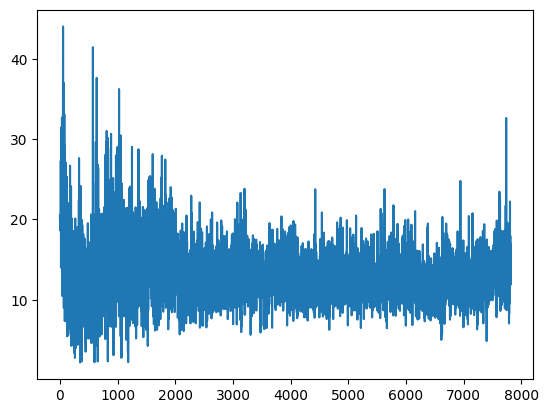

In [45]:
plt.plot(metrics["loss/train-kl"])

In [48]:
import matplotlib.pyplot as plt

plt.plot(metrics["loss/train-img"])

KeyError: 'loss/train-img'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99304533].


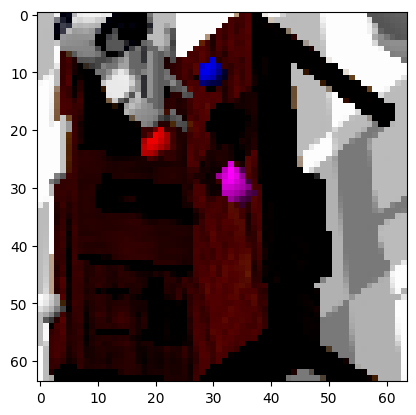

In [20]:
import matplotlib.pyplot as plt

plt.imshow(sample["rgb_obs"]["rgb_static"][0, :,:,:].permute(2,1,0))


In [44]:
batch["rgb_obs"]["rgb_static"].mean()

tensor(0.1230)

In [24]:
metrics

,epoch,loss/train-kl,loss/train-reconstr,loss/train-total,step
0,0,8.177558,7065.824219,7070.615723,0
1,0,8.215250,7154.356445,7159.217773,1
2,0,7.849861,7162.415527,7167.073242,2
3,0,7.854844,7150.966797,7155.668945,3
4,0,8.252019,7299.405273,7304.276367,4
...,...,...,...,...,...
3904,0,1.880541,1589.357666,1590.439697,3904
3905,0,2.452325,1530.385864,1531.804932,3905
3906,0,3.936660,1695.551880,1697.948853,3906
3907,0,2.422901,1844.463013,1846.107178,3907


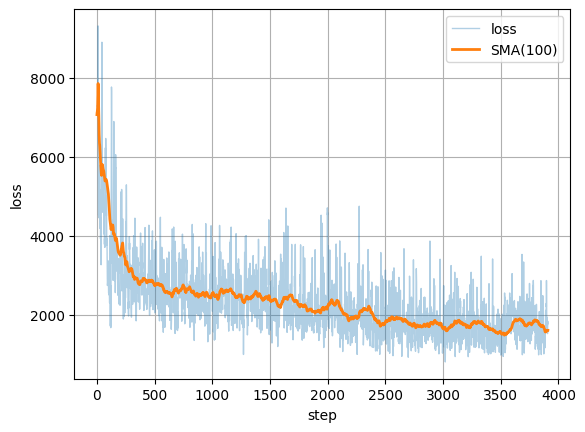

,epoch,loss/train-kl,loss/train-reconstr,loss/train-total,step
0,0,8.177558,7065.824219,7070.615723,0
1,0,8.215250,7154.356445,7159.217773,1
2,0,7.849861,7162.415527,7167.073242,2
3,0,7.854844,7150.966797,7155.668945,3
4,0,8.252019,7299.405273,7304.276367,4
...,...,...,...,...,...
3904,0,1.880541,1589.357666,1590.439697,3904
3905,0,2.452325,1530.385864,1531.804932,3905
3906,0,3.936660,1695.551880,1697.948853,3906
3907,0,2.422901,1844.463013,1846.107178,3907


In [23]:
import pandas as pd
import matplotlib.pyplot as plt


metrics = pd.read_csv("/home/akopyane/rl/lumos/logs/overfit_debug/version_52/metrics.csv")
s = metrics["loss/train-reconstr"].astype(float)
ma = s.rolling(window=100, min_periods=1).mean()

plt.plot(s.index, s, linewidth=1, alpha=0.35, label="loss")
plt.plot(s.index, ma, linewidth=2, label="SMA(100)")
plt.xlabel(s.index.name or "step"); plt.ylabel("loss")
plt.legend(); plt.grid(True); plt.show()
metrics

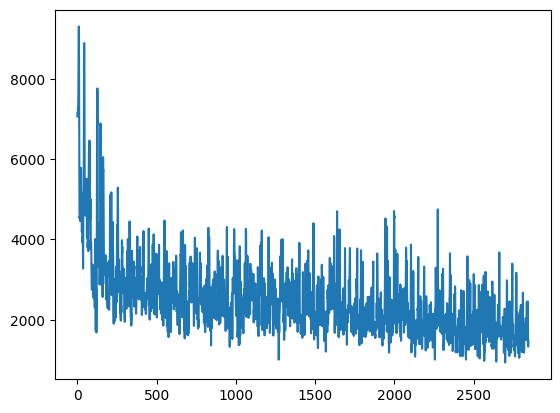

In [20]:
plt.plot(metrics["loss/train-reconstr"])

In [23]:
sample["rgb_obs"]["rgb_static"].shape

torch.Size([10, 3, 64, 64])

In [25]:
sample["rgb_obs"]["rgb_static"][0, :, :, :].shape

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99304533].


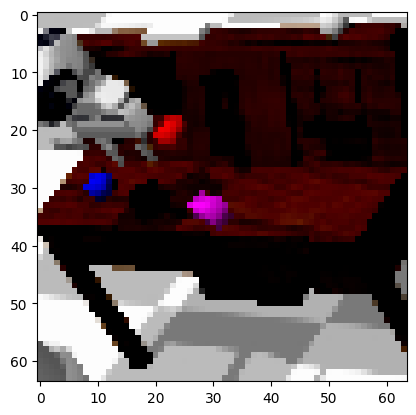

In [27]:
import matplotlib.pyplot as plt
plt.imshow(sample["rgb_obs"]["rgb_static"][0, :, :, :].permute(1, 2, 0).numpy())

In [1]:
OmegaConf.set_struct(cfg, False)
cfg.exp_dir = str(project_root / "logs" / "notebook" / datetime.now().strftime("%Y%m%d_%H%M%S"))
cfg.logger = None
OmegaConf.set_struct(cfg, True)


from pytorch_lightning.loggers import CSVLogger
cfg.logger = None  # disable WandB
csv_logger = CSVLogger(save_dir=str(project_root / "logs"), name="overfit_debug")
trainer = Trainer(logger=csv_logger, **cfg.trainer)


NameError: name 'OmegaConf' is not defined

In [10]:
trainer.fit(model, train_dataloaders=loader, val_dataloaders=loader)  # overfits in 1 epoch

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name            | Type            | Params | Mode
-----------------------------------------------------------
0 | encoder         | CnnEncoder      | 7.8 M  | eval
1 | crssm_core      | ContextRSSMCore | 7.6 M  | eval
2 | precise_decoder | CnnDecoder      | 20.0 M | eval
3 | coarse_decoder  | CnnDecoder      | 19.2 M | eval
-----------------------------------------------------------
54.7 M    Trainable params
0         Non-trainable params
54.7 M    Total params
218.634   Total estimated model params size (MB)
0         Modules in train mode
167       Modules in eval mode
/home/akopyane/rl/lumos/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.
/home/akopyane/rl/lumos/.venv/lib/python3.10/site

Epoch 0:   0%|          | 0/31986 [00:00<?, ?it/s]

Epoch 0:   0%|          | 24/31986 [00:23<8:31:05,  1.04it/s, v_num=31]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/akopyane/rl/lumos/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
model.trainer

: 

: 

In [ ]:
y_2 = torch.ones((16,256 + 16)).to("cuda")
y_21 = torch.ones((16,256)).to("cuda")

: 

: 

: 

In [ ]:
model = model.to("cuda")

: 

: 

: 

: 

: 

: 

In [ ]:
model.crssm_core.cell.gru(y_2, y_21)

tensor([[0.8410, 0.8793, 0.3895,  ..., 0.3006, 0.3278, 0.8178],
        [0.8410, 0.8793, 0.3895,  ..., 0.3006, 0.3278, 0.8178],
        [0.8410, 0.8793, 0.3895,  ..., 0.3006, 0.3278, 0.8178],
        ...,
        [0.8410, 0.8793, 0.3895,  ..., 0.3006, 0.3278, 0.8178],
        [0.8410, 0.8793, 0.3895,  ..., 0.3006, 0.3278, 0.8178],
        [0.8410, 0.8793, 0.3895,  ..., 0.3006, 0.3278, 0.8178]],
       device='cuda:0', grad_fn=<CatBackward0>)

: 

: 

: 

In [ ]:
model.crssm_core.cell.gru

GRUCellStack(
  (layers): ModuleList(
    (0): GRUCell(256, 256)
  )
)

: 

: 

: 

In [ ]:
for i in range(batch["robot_obs"].shape[1]):
    print(model.encoder.encoder_state(batch["hybrid"]["robot_obs"].float().to("cuda")[:, i, ...]).shape)

AttributeError: 'CnnEncoder' object has no attribute 'encoder_state'

: 

: 

: 

In [ ]:
batch["rgb_obs"]["rgb_static"].shape

torch.Size([10, 1, 3, 34, 34])

: 

: 

: 

In [ ]:
model.encoder.encoder_static

Sequential(
  (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ELU(alpha=1.0)
  (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ELU(alpha=1.0)
  (4): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ELU(alpha=1.0)
  (6): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ELU(alpha=1.0)
  (8): Flatten(start_dim=1, end_dim=-1)
)

: 

: 

: 

In [ ]:
model.encoder.encoder_gripper

Sequential(
  (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2))
  (1): ELU(alpha=1.0)
  (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
  (3): ELU(alpha=1.0)
  (4): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2))
  (5): ELU(alpha=1.0)
  (6): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2))
  (7): ELU(alpha=1.0)
  (8): Flatten(start_dim=1, end_dim=-1)
)

: 

: 

: 

In [ ]:
model.precise_decoder

CnnDecoder(
  (activation): ELU(alpha=1.0)
  (decoder_static): Sequential(
    (0): Linear(in_features=1296, out_features=1536, bias=True)
    (1): Unflatten(dim=-1, unflattened_size=(1536, 1, 1))
    (2): ConvTranspose2d(1536, 192, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): ConvTranspose2d(192, 96, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): ConvTranspose2d(96, 48, kernel_size=(6, 6), stride=(2, 2))
    (7): ELU(alpha=1.0)
    (8): ConvTranspose2d(48, 3, kernel_size=(6, 6), stride=(2, 2))
  )
  (decoder_gripper): Sequential(
    (0): Linear(in_features=1296, out_features=1536, bias=True)
    (1): Unflatten(dim=-1, unflattened_size=(1536, 1, 1))
    (2): ConvTranspose2d(1536, 192, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): ConvTranspose2d(192, 96, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): ConvTranspose2d(96, 48, kernel_size=(6, 6), stride=(2, 2))
    (7): ELU(alpha=1.0)
    (8): ConvTran

: 

: 

: 

In [ ]:
batch["rgb_obs"]["rgb_static"].shape

torch.Size([10, 1, 3, 34, 34])

: 

: 

: 

In [ ]:
batch["rgb_obs"]["rgb_gripper"].shape

torch.Size([10, 1, 3, 34, 34])

: 

: 

: 

In [ ]:
torch.ones(16 + 256 + 32*32).shape

torch.Size([1296])

: 

: 

: 

In [ ]:
dcd_img_s, dcd_img_g = model.coarse_decoder(torch.ones(16 + 32*32).to("cuda"))

: 

: 

: 

In [ ]:
dcd_img_s.shape

torch.Size([3, 64, 64])

: 

: 

: 

In [ ]:
dcd_img_s, dcd_img_g = model.precise_decoder(torch.ones(16 + 256 + 32*32).to("cuda"))

: 

: 

: 

In [ ]:
model

DreamerV2ContextRSSM(
  (encoder): CnnEncoder(
    (activation): ELU(alpha=1.0)
    (encoder_static): Sequential(
      (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2))
      (1): ELU(alpha=1.0)
      (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
      (3): ELU(alpha=1.0)
      (4): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2))
      (5): ELU(alpha=1.0)
      (6): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2))
      (7): ELU(alpha=1.0)
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (encoder_gripper): Sequential(
      (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2))
      (1): ELU(alpha=1.0)
      (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
      (3): ELU(alpha=1.0)
      (4): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2))
      (5): ELU(alpha=1.0)
      (6): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2))
      (7): ELU(alpha=1.0)
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (fuse): Sequential(
      (0): Linear(in_featur

: 

: 

: 

In [ ]:
dcd_img_s.shape

torch.Size([3, 64, 64])

: 

: 

: 

In [ ]:
for i in range(batch["rgb_obs"]["rgb_static"].shape[0]):
    print(model.encoder.encoder_static(batch["rgb_obs"]["rgb_static"].float().to("cuda")[i, ...]).shape)

torch.Size([1, 1536])
torch.Size([1, 1536])
torch.Size([1, 1536])
torch.Size([1, 1536])
torch.Size([1, 1536])
torch.Size([1, 1536])
torch.Size([1, 1536])
torch.Size([1, 1536])
torch.Size([1, 1536])
torch.Size([1, 1536])


: 

: 

: 

In [ ]:
for i in range(batch["hybrid"]["rgb_obs"]["rgb_static"].shape[0]):
    print(model.encoder.encoder_static(batch["hybrid"]["rgb_obs"]["rgb_static"].float().to("cuda")[i, ...]).shape)

torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size([8, 38400])
torch.Size(

: 

: 

: 

In [ ]:
model

DreamerV2ContextRSSM(
  (encoder): CnnMLPEncoder(
    (activation): ELU(alpha=1.0)
    (encoder_static): Sequential(
      (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2))
      (1): ELU(alpha=1.0)
      (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
      (3): ELU(alpha=1.0)
      (4): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2))
      (5): ELU(alpha=1.0)
      (6): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2))
      (7): ELU(alpha=1.0)
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (encoder_gripper): Sequential(
      (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2))
      (1): ELU(alpha=1.0)
      (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
      (3): ELU(alpha=1.0)
      (4): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2))
      (5): ELU(alpha=1.0)
      (6): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2))
      (7): ELU(alpha=1.0)
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (fuse): Sequential(
      (0): Linear(in_fea

: 

: 

: 

In [ ]:
batch = next(iter(loader)) #["hybrid"]


for key in batch["hybrid"].keys():
    if type(batch["hybrid"][key]) is torch.Tensor:
        print(key, batch["hybrid"][key].dtype, "shape:", batch["hybrid"][key].shape)
    if type(batch["hybrid"][key]) is dict:
        for k in batch["hybrid"][key].keys():
            print("  ", k, batch["hybrid"][key][k].dtype, "shape:", batch["hybrid"][key][k].shape)

robot_obs torch.float32 shape: torch.Size([8, 50, 15])
   rgb_static torch.uint8 shape: torch.Size([50, 8, 3, 200, 200])
   rgb_gripper torch.uint8 shape: torch.Size([50, 8, 3, 84, 84])
   rel_actions torch.float32 shape: torch.Size([50, 8, 7])
   pre_actions torch.float32 shape: torch.Size([50, 8, 7])
   robot_obs torch.float64 shape: torch.Size([50, 8, 15])
   pre_robot_obs torch.float64 shape: torch.Size([50, 8, 15])
lang torch.float32 shape: torch.Size([8, 0])
reset torch.bool shape: torch.Size([50, 8, 1])
frame torch.int32 shape: torch.Size([50, 8, 1])
idx torch.int64 shape: torch.Size([8])


: 

: 

: 

In [ ]:
batch['hybrid'].keys()

dict_keys(['robot_obs', 'rgb_obs', 'depth_obs', 'actions', 'state_info', 'lang', 'reset', 'frame', 'idx'])

: 

: 

: 

In [ ]:
batch['hybrid']["rgb_obs"]["rgb_static"].shape

torch.Size([50, 8, 3, 200, 200])

: 

: 

: 

In [ ]:
from copy import deepcopy
from pathlib import Path

import hydra
from omegaconf import OmegaConf

# Clone the datamodule block so we can mutate it safely
dm_cfg = OmegaConf.create(deepcopy(OmegaConf.to_container(cfg.datamodule, resolve=True)))
OmegaConf.set_struct(dm_cfg, False)

# Replace the legacy calvin data module with the surviving BaseDataModule
dm_cfg._target_ = "lumos.datasets.base_data_module.BaseDataModule"
dm_cfg.training_repo_root = Path.cwd()

# The actual WM dataset config lives at datasets.vision_dataset.vision_wm
dataset_cfg = dm_cfg.datasets.vision_dataset.vision_wm
OmegaConf.set_struct(dataset_cfg, False)
dataset_cfg._target_ = "lumos.datasets.hybrid_wm_disk_dataset.HybridWMDiskDataset"
dataset_cfg.save_format = "npz"
dataset_cfg.reset_prob = dm_cfg.get("reset_prob", 0.01)
dataset_cfg.for_wm = True
OmegaConf.set_struct(dataset_cfg, True)

OmegaConf.set_struct(dm_cfg, True)

# Instantiate – this builds the resize/normalize transforms for you
dm = hydra.utils.instantiate(dm_cfg)
dm.prepare_data()
dm.setup()

# Grab a time-major batch with the correct image size/normalization
batch = next(iter(dm.train_dataloader()["vis"]))


ConfigAttributeError: Missing key vision_wm
    full_key: datasets.vision_dataset.vision_wm
    object_type=dict

: 

: 

: 